In [ ]:
#pip install -q accelerate -U

### ***Setup***

In [ ]:
!pip install transformers
!pip install torch
!pip install evaluate
!pip install datasets

In [ ]:
import sklearn
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import evaluate
import gc
import numpy as np
from torch import nn
from transformers import Trainer
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

2023-12-05 17:47:00.125809: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 17:47:02.928657: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 17:47:04.076516: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 17:47:19.226964: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [ ]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline, AutoModel

checkpoint = 'seyonec/PubChem10M_SMILES_BPE_450k'
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,num_labels=2).to(device)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

Some weights of the model checkpoint at seyonec/PubChem10M_SMILES_BPE_450k were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_45

### ***loading data***

In [ ]:
train = pd.read_csv('train_data.txt', sep='\t')
train = train.rename(columns={'Smiles String': 'Smiles', 'agg' : 'label'})

test_agg = pd.read_csv('agg_data_test.txt', sep='\t')
test_agg['label']='AGG'
test_agg.drop('ID', axis=1, inplace = True)

test_non_agg= pd.read_csv('nonagg_data_test.txt', sep='\t')
test_non_agg['label']='NONAGG'
test_non_agg.drop('ID', axis=1, inplace = True)

data = pd.concat([test_agg, test_non_agg, train], ignore_index=True)

data = data.rename(columns={'label': 'labels','Smiles' : 'smiles' })

label_map = {
    'AGG': 1,
    'NONAGG': 0,
}

data = data.drop('Unnamed: 0', axis=1 )
data['labels'] = data['labels'].map(label_map)
data.dropna(inplace=True)

In [ ]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state = 42, stratify=data['labels'])
train_df, valid_df = train_test_split(train_df, test_size=0.2, random_state = 42,  stratify=train_df['labels'])

<AxesSubplot:>

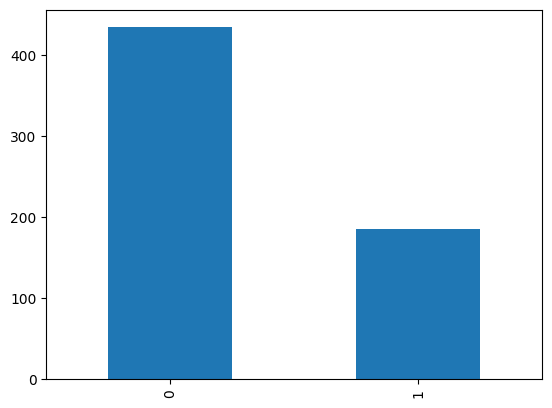

In [ ]:
train_df['labels'].value_counts().plot.bar()

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Create a pipeline with both oversampling and undersampling steps
pipeline = Pipeline([
    ('over', RandomOverSampler(sampling_strategy=0.5)),  # Adjust sampling_strategy as needed
    ('under', RandomUnderSampler(sampling_strategy=1.0))  # Adjust sampling_strategy as needed
])

# Fit and apply the pipeline to the dataset
X_resampled, y_resampled = pipeline.fit_resample(train_df.drop('labels', axis=1), train_df['labels'])

# Combine the resampled features and labels into a new DataFrame
train_df = pd.DataFrame(X_resampled, columns=train_df.drop('labels', axis=1).columns)
train_df['labels'] = y_resampled

<AxesSubplot:>

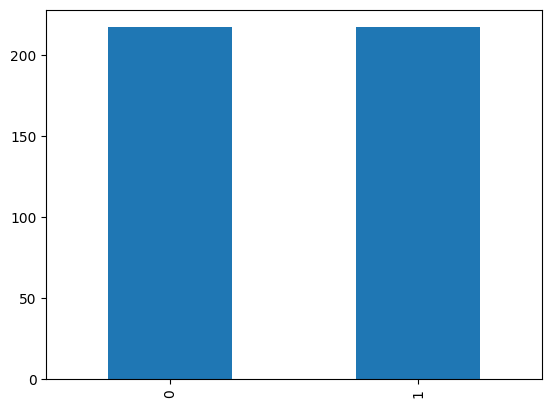

In [ ]:
train_df['labels'].value_counts().plot.bar()

In [ ]:
from datasets import Dataset, DatasetDict

ds_dict = {'train' : Dataset.from_pandas(train_df),
           'valid' : Dataset.from_pandas(valid_df),
           'test' : Dataset.from_pandas(test_df)}

ds = DatasetDict(ds_dict)

In [ ]:
def tokenize_function(examples):

    return tokenizer(examples["smiles"])#,truncation=True)

tokenized_datasets = ds.map(tokenize_function, batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
tokenized_train=tokenized_datasets['train']
tokenized_valid=tokenized_datasets['valid']

In [ ]:
from transformers import DataCollatorWithPadding

#Data collator that will dynamically pad the inputs received.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
def compute_metrics(p):
    pred, labels = p
    pred = np.argmax(pred, axis=1)
    accuracy = accuracy_score(y_true=labels, y_pred=pred)
    f1 = f1_score(y_true=labels, y_pred=pred)
    geometric_mean = geometric_mean_score(y_true=labels, y_pred=pred)

    return {"accuracy": accuracy, "f1": f1, "geometric_mean": geometric_mean}

In [ ]:
from collections import Counter

print(dict(Counter(tokenized_train['labels'])))

{0: 217, 1: 217}


### ***Training***

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels").to(device)
        inputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in inputs.items()}
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get('logits')
        # compute custom loss
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([0.5, 0.85]).to(device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

In [ ]:
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback,  IntervalStrategy

training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy=IntervalStrategy.STEPS,
report_to="none", num_train_epochs=5, load_best_model_at_end=True, save_total_limit = 5,
metric_for_best_model = 'accuracy', eval_steps = 500, greater_is_better=True, learning_rate=2e-5,
lr_scheduler_type='linear')

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train ,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    data_collator= data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.000085)]
)

PyTorch: setting up devices


In [ ]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=275, training_loss=0.03428974498401988, metrics={'train_runtime': 8.8117, 'train_samples_per_second': 246.262, 'train_steps_per_second': 31.208, 'total_flos': 23972977001304.0, 'train_loss': 0.03428974498401988, 'epoch': 5.0})

### ***Evaluation***

The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: __index_level_0__, smiles. If __index_level_0__, smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


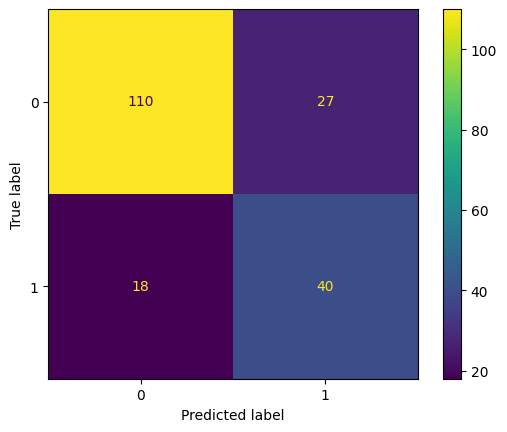

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test = tokenized_datasets["test"]
model_logits=trainer.predict(test)
pred_labels=model_logits.predictions.argmax(axis=1)

cm = confusion_matrix(test['labels'], pred_labels)
ConfusionMatrixDisplay(cm).plot()

In [ ]:
precision_metric = evaluate.load("precision")
results = precision_metric.compute(references=test['labels'], predictions=pred_labels)

print(results)

recall_metric = evaluate.load("recall")
results = recall_metric.compute(references=test['labels'], predictions=pred_labels)

print(results)

f1_metric = evaluate.load("f1")
results = f1_metric.compute(references=test['labels'], predictions=pred_labels)

print(results)

acc_metric = evaluate.load("accuracy")
results = acc_metric.compute(references=test['labels'], predictions=pred_labels)

print(results)



{'precision': 0.5970149253731343}
{'recall': 0.6896551724137931}
{'f1': 0.64}
{'accuracy': 0.7692307692307693}


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt


def roc_curve_plot(fpr,tpr,roc_auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

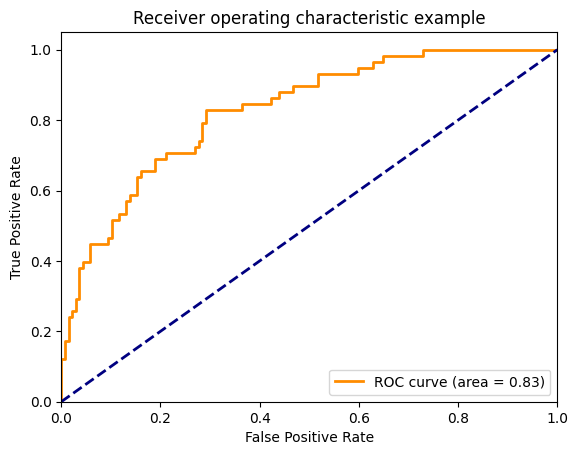

In [ ]:
logits_pt = torch.from_numpy(model_logits.predictions)
probabilities = nn.functional.softmax(logits_pt, dim=-1)
y_predict_prob= probabilities[:,1]

fpr, tpr, _ = roc_curve(test_df['labels'], y_predict_prob)
roc_auc = auc(fpr, tpr)
roc_curve_plot(fpr,tpr,roc_auc)

In [ ]:
tn, fp, fn, tp = cm.ravel()

sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
ccr = (specificity+ sensitivity)/2
ppv = (tp / (tp + fp))
npv = (tn / (tn + fn)) if (tn + fn) > 0 else 0

In [ ]:
print("sensitivity Results: {}".format(sensitivity))
print("specifity Results: {}".format(specificity))
print("ccr Results: {}".format(ccr))
print("npv Results: {}".format(npv))
print("ppv Results: {}".format(ppv))

sensitivity Results: 0.6896551724137931
specifity Results: 0.8029197080291971
ccr Results: 0.7462874402214952
npv Results: 0.859375
ppv Results: 0.5970149253731343


## 10 runs

In [ ]:
def runs(random_seed_list, data):

  ccr_list = []
  sen_list = []
  spe_list = []
  ppv_list = []
  npv_list = []
  auc_list = []
  i = 1

  for seed in random_seed_list:

        train_df1, test_df1 = train_test_split(data, test_size=0.2, random_state = seed, stratify=data['labels'])
        train_df1, valid_df1 = train_test_split(train_df1, test_size=0.2, random_state = seed,  stratify=train_df1['labels'])

        train_df1 = train_df1.reset_index(drop=True)
        valid_df1 = valid_df1.reset_index(drop=True)
        test_df1 = test_df1.reset_index(drop=True)

        # class balancing
        X_resampled, y_resampled = pipeline.fit_resample(train_df1.drop('labels', axis=1), train_df1['labels'])

        # Combine the resampled features and labels into a new DataFrame
        train_df1 = pd.DataFrame(X_resampled, columns=train_df1.drop('labels', axis=1).columns)
        train_df1['labels'] = y_resampled

        #datasets
        ds_dict = {'train' : Dataset.from_pandas(train_df1),
           'valid' : Dataset.from_pandas(valid_df1),
           'test' : Dataset.from_pandas(test_df1)}

        ds = DatasetDict(ds_dict)

        tokenized_datasets = ds.map(tokenize_function, batched=True)

        tokenized_train=tokenized_datasets['train']
        tokenized_valid=tokenized_datasets['valid']



        trainer = Trainer(
                            model=model,
                            args=training_args,
                            train_dataset=tokenized_train ,
                            eval_dataset=tokenized_valid,
                            compute_metrics=compute_metrics,
                            data_collator= data_collator,
                            callbacks=[EarlyStoppingCallback(early_stopping_patience=3, early_stopping_threshold=0.0001)]
                        )

        trainer.train()

        #evaluation
        test = tokenized_datasets["test"]
        model_logits=trainer.predict(test)
        pred_labels=model_logits.predictions.argmax(axis=1)

        cm = confusion_matrix(test['labels'], pred_labels)

        tn, fp, fn, tp = cm.ravel()

        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        ccr = (specificity+ sensitivity)/2
        ppv = (tp / (tp + fp))
        npv = (tn / (tn + fn))

        logits_pt = torch.from_numpy(model_logits.predictions)
        probabilities = nn.functional.softmax(logits_pt, dim=-1)
        y_predict_prob= probabilities[:,1]

        fpr, tpr, _ = roc_curve(test['labels'], y_predict_prob)
        roc_auc = auc(fpr, tpr)


        ccr_list.append(ccr)
        sen_list.append(sensitivity)
        spe_list.append(specificity)
        ppv_list.append(ppv)
        npv_list.append(npv)
        auc_list.append(roc_auc)

        print('finished run:', i)
        i = i+1

  return ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list

In [ ]:
random_seed_list = [123, 80, 789, 567, 890, 345, 678, 901, 456, 12]

In [ ]:
ccr_list, sen_list, spe_list, ppv_list, npv_list, auc_list = runs(random_seed_list, data)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 1


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 2


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 3


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 4


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 5


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 6


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 7


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 8


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 9


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
/home/farah.alharthi/.conda/envs/ai701/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 434
  Num Epochs = 5
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 275
  Number of trainable parameters = 83450882


Step,Training Loss,Validation Loss




Training completed. Do not forget to share your model on huggingface.co/models =)


The following columns in the test set don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: smiles. If smiles are not expected by `RobertaForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 195
  Batch size = 8


finished run: 10


In [ ]:
# Calculate mean and standard deviation
ccr_mean = np.mean(ccr_list)
ccr_std = np.std(ccr_list)

sen_mean = np.mean(sen_list)
sen_std = np.std(sen_list)

spe_mean = np.mean(spe_list)
spe_std = np.std(spe_list)

ppv_mean = np.mean(ppv_list)
ppv_std = np.std(ppv_list)

npv_mean = np.mean(npv_list)
npv_std = np.std(npv_list)

auc_mean = np.mean(auc_list)
auc_std = np.std(auc_list)

# Print the results
print(f'Mean and Standard Deviation of CCR: {ccr_mean:.2f} ± {ccr_std:.2f}')
print(f'Mean and Standard Deviation of Sensitivity: {sen_mean:.2f} ± {sen_std:.2f}')
print(f'Mean and Standard Deviation of Specificity: {spe_mean:.2f} ± {spe_std:.2f}')
print(f'Mean and Standard Deviation of PPV: {ppv_mean:.2f} ± {ppv_std:.2f}')
print(f'Mean and Standard Deviation of NPV: {npv_mean:.2f} ± {npv_std:.2f}')
print(f'Mean and Standard Deviation of AUC: {auc_mean:.2f} ± {auc_std:.2f}')

Mean and Standard Deviation of CCR: 0.96 ± 0.04
Mean and Standard Deviation of Sensitivity: 0.98 ± 0.03
Mean and Standard Deviation of Specificity: 0.95 ± 0.04
Mean and Standard Deviation of PPV: 0.90 ± 0.08
Mean and Standard Deviation of NPV: 0.99 ± 0.01
Mean and Standard Deviation of AUC: 0.99 ± 0.02
